#  Analyse spectra holo at AuxTel for Configurations


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- 
- creation date : September 22th  2022
- last update : October 11th 2022


- **kernel anaconda3_auxtel** at CC or **python 3** locally

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

/opt/conda/lib/python3.8/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

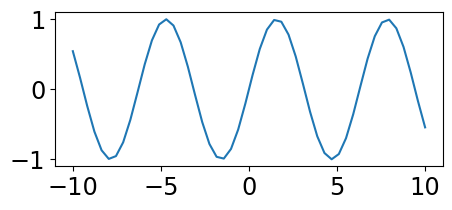

In [3]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               

In [4]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [5]:
from datetime import datetime,date

In [6]:
#pip install fpdf
#from fpdf import FPDF

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [7]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [8]:
string_date

'2022-10-11'

In [9]:
from iminuit import Minuit
import iminuit

In [10]:
iminuit.__version__

'2.8.4'

In [11]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor,dumpParameters,dumpfitparameters
from spectractor.extractor.spectrum import Spectrum, detect_lines, calibrate_spectrum
from spectractor.extractor.spectrum import *
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, HGAMMA, HDELTA ,O2_1, O2_2, O2B,H2O_1, ATMOSPHERIC_LINES
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy.interpolate import interp1d

In [12]:
from time import sleep

In [13]:
from astropy.time import Time
import astropy.units as u

In [14]:
import pickle

# Calibration line

In [15]:
ATMOSPHERIC_LINES_CALIB = [O2B,O2_1, O2_2]
HYDROGEN_LINES_CALIB = [HALPHA, HBETA, HGAMMA, HDELTA]

setatml = set(ATMOSPHERIC_LINES_CALIB)
sethdryl = set(HYDROGEN_LINES_CALIB )

LINES_CALIB = list(sethdryl.union(setatml))

lines_calib = Lines(LINES_CALIB , hydrogen_only=True,atmospheric_lines=True, redshift=0, emission_spectrum=False)

# Function

In [16]:
def file_tag_forsorting(filename):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('^exposure_.*([0-9][0-9][0-9][0-9][0-9])_postisrccd.*', filename)
    if len(m)>0:
        return m[0]
    else:
        return None


In [17]:
def subdir_tag_forsorting(subdir):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('.*([0-9][0-9][0-9][0-9][0-9])$', subdir)
    if len(m)>0:
        return m[0]
    else:
        return None


In [18]:
file_tag_forsorting('exposure_2022031600330_postisrccd.fits')

'00330'

In [19]:
subdir_tag_forsorting('2022031600330')

'00330'

# Config

In [20]:
# path index for each month
DATE="20220629"
#DATE="20211104"
#filterdispersername = "empty~holo4_003"
filterdispersername = "BG40~holo4_003"
#filterdispersername = "FELH0600~holo4_003"
imagemode = "postISRCCD"
#imagemode = "unflattened"
FLAG_RECALIB = False

In [21]:
version="v5.0"

In [22]:
# Choose the config filename
list_of_spectractorconfigfiles= ['auxtel_config_holo_DECONVOLUTION_PSF1D.ini' ,
                                 'auxtel_config_holo_DECONVOLUTION_PSF2D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_FFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF2DFFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2FFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DFFM300650.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF2D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotA.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotB.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotC.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotD.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF1D_BG40.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF1DTRUNC.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF2DTRUNC.ini']
config_idx = 3
                                
configfilename= os.path.join("./config",list_of_spectractorconfigfiles[config_idx])
#configdir = (list_of_spectractorconfigfiles[config_idx].split("_")[-1]).split(".") [0]
configdir = "config_" + (list_of_spectractorconfigfiles[config_idx].split("auxtel_config_holo_")[-1]).split(".") [0]

In [23]:
configdir 

'config_DECONVOLUTION_PSF2D'

In [24]:
config=configfilename
print(f">>>>> Spectractor configuration filename : {configfilename}")

>>>>> Spectractor configuration filename : ./config/auxtel_config_holo_DECONVOLUTION_PSF2D.ini


In [25]:
load_config(configfilename)

No rebinning: parameters.REBIN is forced to 1.


In [26]:
configmode = list_of_spectractorconfigfiles[config_idx].split("auxtel_config_holo_DECONVOLUTION_")[-1].split(".") [0]
configmode

'PSF2D'

## Parameters

In [27]:
dumpParameters()

ASTROMETRYNET_DIR 
BGD_ORDER 1
CALIB_BGD_NPARAMS 4
CALIB_BGD_ORDER 3
CALIB_BGD_WIDTH 15
CALIB_PEAK_WIDTH 7
CALIB_SAVGOL_ORDER 2
CALIB_SAVGOL_WINDOW 5
CCD_ARCSEC2RADIANS 4.84813681109536e-06
CCD_GAIN 1.1
CCD_IMSIZE 4096
CCD_MAXADU 170000
CCD_PIXEL2ARCSEC 0.0952
CCD_PIXEL2MM 0.01
CCD_REBIN 1
CONFIG_DIR /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/../config/
DEBUG False
DEBUG_LOGGING False
DISPERSER_DIR /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/
DISPLAY False
DISTANCE2CCD 175
DISTANCE2CCD_ERR 0.75
FGB37 {'label': 'FGB37', 'min': 350, 'max': 750}
FILTERS [{'label': 'RG715', 'min': 690, 'max': 1100}, {'label': 'FGB37', 'min': 350, 'max': 750}, {'label': 'Halfa', 'min': 0.0006431, 'max': 0.0006686999999999999}, {'label': 'Z-Gunn', 'min': 800, 'max': 1100}]
FLAM_TO_ADURATE 5175865186660.421
GRATING_ORDER_2OVER1 0.1
GROOVES_PER_MM 350
HAL

# Path

In [28]:
HOSTCC=True
LAPTOP=False

In [29]:
# Set path depending on which computer running (according HOSTCC)
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
    if configdir == "":
        path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
    else:
        path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
        path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
        path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
        path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)

else:
    if not LAPTOP:
        path_auxtel="/Users/sylvie/DATA/AuxTelData2022"
        path_spectractor=os.path.join(path_auxtel,"/Users/sylvie/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)
    else:
        path_auxtel="/Users/dagoret/DATA/AuxTelData2022"
        path_spectractor=os.path.join(path_auxtel,"/Users/dagoret/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)
        


In [30]:
path_output_spectractor

'/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629'

In [31]:
! ls -l $path_output_spectractor

total 0
drwxrws--- 1 dagoret lsst 2 Oct  6 22:38 2022062900054
drwxrws--- 1 dagoret lsst 2 Oct  7 01:09 2022062900055
drwxrws--- 1 dagoret lsst 2 Oct  7 03:40 2022062900056
drwxrws--- 1 dagoret lsst 2 Oct  6 21:37 2022062900084
drwxrws--- 1 dagoret lsst 2 Oct  7 00:16 2022062900110
drwxrws--- 1 dagoret lsst 2 Oct  6 21:24 2022062900113
drwxrws--- 1 dagoret lsst 2 Oct  6 21:57 2022062900137
drwxrws--- 1 dagoret lsst 2 Oct  6 21:37 2022062900138
drwxrws--- 1 dagoret lsst 2 Oct  6 22:37 2022062900139
drwxrws--- 1 dagoret lsst 2 Oct  6 22:25 2022062900164
drwxrws--- 1 dagoret lsst 2 Oct  7 00:45 2022062900165
drwxrws--- 1 dagoret lsst 2 Oct  6 21:42 2022062900166
drwxrws--- 1 dagoret lsst 2 Oct  7 00:37 2022062900201
drwxrws--- 1 dagoret lsst 2 Oct  6 22:29 2022062900203
drwxrws--- 1 dagoret lsst 2 Oct  7 02:12 2022062900204
drwxrws--- 1 dagoret lsst 2 Oct  6 21:23 2022062900271
drwxrws--- 1 dagoret lsst 2 Oct  6 23:20 2022062900272
drwxrws--- 1 dagoret lsst 2 Oct  6 22:36 2022062900273
dr

In [32]:
# standard configuration for spectractor
#config = os.path.join(path_spectractor_config,"auxtel.ini")
#config=os.path.join("./config",configfilename)
config=configfilename
print(f">>>>> Spectractor configuration filename : {configfilename}")

>>>>> Spectractor configuration filename : ./config/auxtel_config_holo_DECONVOLUTION_PSF2D.ini


In [33]:
load_config(configfilename)

No rebinning: parameters.REBIN is forced to 1.


## Logbook for file selection

In [34]:
filename_logbook='logbooks/auxtellogbook_'+filterdispersername+"_"+DATE+'_' + version+'.csv'

In [35]:
df=pd.read_csv(filename_logbook,index_col=0)

In [36]:
pd.set_option('display.max_rows', None)

In [37]:
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2022-06-29T23:19:13.975,/sps/lsst/groups/auxtel/data/2022/BG40~holo4_0...,exposure_2022062900054_postisrccd.fits,54,HD142331,BG40,holo4_003,1.404038,30.0,...,9.5,12.0,4.7,NaN,NaN,NaN,NaN,,NaN,NaN
1,1,2022-06-29T23:19:56.890,/sps/lsst/groups/auxtel/data/2022/BG40~holo4_0...,exposure_2022062900055_postisrccd.fits,55,HD142331,BG40,holo4_003,1.400535,30.0,...,9.5,12.0,4.7,NaN,NaN,NaN,NaN,,NaN,NaN
2,2,2022-06-29T23:20:39.816,/sps/lsst/groups/auxtel/data/2022/BG40~holo4_0...,exposure_2022062900056_postisrccd.fits,56,HD142331,BG40,holo4_003,1.397078,30.0,...,9.5,12.0,4.6,NaN,NaN,NaN,NaN,,NaN,NaN
3,3,2022-06-30T00:29:31.328,/sps/lsst/groups/auxtel/data/2022/BG40~holo4_0...,exposure_2022062900084_postisrccd.fits,84,HD142331,BG40,holo4_003,1.169894,30.0,...,9.7,12.0,1.1,NaN,NaN,NaN,NaN,,NaN,NaN
4,4,2022-06-30T00:47:21.203,/sps/lsst/groups/auxtel/data/2022/BG40~holo4_0...,exposure_2022062900110_postisrccd.fits,110,HD142331,BG40,holo4_003,1.136675,30.0,...,9.9,16.0,2.3,NaN,NaN,NaN,NaN,,NaN,NaN
5,5,2022-06-30T00:49:30.135,/sps/lsst/groups/auxtel/data/2022/BG40~holo4_0...,exposure_2022062900113_postisrccd.fits,113,HD142331,BG40,holo4_003,1.133213,30.0,...,9.9,17.0,3.1,NaN,NaN,NaN,NaN,,NaN,NaN
6,6,2022-06-30T01:05:55.949,/sps/lsst/groups/auxtel/data/2022/BG40~holo4_0...,exposure_2022062900137_postisrccd.fits,137,HD142331,BG40,holo4_003,1.110361,30.0,...,9.7,16.0,3.8,NaN,NaN,NaN,NaN,,NaN,NaN
7,7,2022-06-30T01:06:38.896,/sps/lsst/groups/auxtel/data/2022/BG40~holo4_0...,exposure_2022062900138_postisrccd.fits,138,HD142331,BG40,holo4_003,1.109500,30.0,...,9.6,16.0,3.6,NaN,NaN,NaN,NaN,,NaN,NaN
8,8,2022-06-30T01:07:22.060,/sps/lsst/groups/auxtel/data/2022/BG40~holo4_0...,exposure_2022062900139_postisrccd.fits,139,HD142331,BG40,holo4_003,1.108647,30.0,...,9.7,15.0,3.8,NaN,NaN,NaN,NaN,,NaN,NaN
9,9,2022-06-30T01:24:30.369,/sps/lsst/groups/auxtel/data/2022/BG40~holo4_0...,exposure_2022062900164_postisrccd.fits,164,HD142331,BG40,holo4_003,1.091658,30.0,...,9.8,15.0,3.4,NaN,NaN,NaN,NaN,,NaN,NaN


## Selection of input files

In [38]:
df_good=df
df_good["quality"] = 1

In [39]:
for spectra_file in df_good["file"]:
    print(spectra_file)

exposure_2022062900054_postisrccd.fits
exposure_2022062900055_postisrccd.fits
exposure_2022062900056_postisrccd.fits
exposure_2022062900084_postisrccd.fits
exposure_2022062900110_postisrccd.fits
exposure_2022062900113_postisrccd.fits
exposure_2022062900137_postisrccd.fits
exposure_2022062900138_postisrccd.fits
exposure_2022062900139_postisrccd.fits
exposure_2022062900164_postisrccd.fits
exposure_2022062900165_postisrccd.fits
exposure_2022062900166_postisrccd.fits
exposure_2022062900201_postisrccd.fits
exposure_2022062900203_postisrccd.fits
exposure_2022062900204_postisrccd.fits
exposure_2022062900271_postisrccd.fits
exposure_2022062900272_postisrccd.fits
exposure_2022062900273_postisrccd.fits
exposure_2022062900274_postisrccd.fits
exposure_2022062900298_postisrccd.fits
exposure_2022062900299_postisrccd.fits
exposure_2022062900300_postisrccd.fits
exposure_2022062900325_postisrccd.fits
exposure_2022062900327_postisrccd.fits
exposure_2022062900328_postisrccd.fits
exposure_2022062900359_po

## Selection of Spectractor output files

In [40]:
# total number of exposures
NBEXP=0
# total number of exposures without dir
NBEXPNODIR=0
# total number of exposures with dir
NBEXPWTHDIR=0
# total number of exposures with plots
NBEXPWTHPLT=0
# total number of exposures with spectra
NBEXPWTHSPEC=0

# list of exposures
LISTNUM=[]
# list of exposure without dir (not run spectraction)
LISTNUMNODIR=[]
# list of exposure with dir (spectraction has been run)
LISTNUMWTHDIR=[]
# list of exposures with plots (Spectractor has run up to some point)
LISTNUMWTHPLOTS=[]
# list of exposures with spectraction output (Spectractor has completed)
LISTNUMWTHSPECTR=[]

# list of selected spectra path
List_of_spectra_path=[]

In [41]:
list_of_files=os.listdir(path_output_spectractor)
list_of_files=sorted(list_of_files)


print("list of subdir found ",list_of_files)

for subdir in list_of_files:
    
    
    #tag = file_tag_forsorting(subdir)
    tag = subdir_tag_forsorting(subdir)
    
        
    print(tag)    
    #if tag is not None and int(tag)<317:
    #    continue
    if tag is None :
        continue
  
    
    
    fulldir=os.path.join(path_output_spectractor,subdir)



    if not os.path.isdir(fulldir):
        
        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is not a directory".format(subdir))
        

        NBEXPNODIR+=1


    else:

        
        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is a directory".format(subdir))

        tagname=subdir_tag_forsorting(subdir)
        print("tagname= {}".format(tagname))
        #targetname=file_target(subdir)
        #print("targetname= {}".format(targetname))
        



        NBEXP += 1
        LISTNUM.append(tagname)



        dir_plots=os.path.join(fulldir,"plots")
        dir_spectration = os.path.join(fulldir, "basespec")

        flag_empty1 = True
        flag_empty2 = True


        if os.path.isdir(dir_plots):
            if any(os.scandir(dir_plots)):
                print("dir_plots is not empty")
                NBEXPWTHPLT+=1
                LISTNUMWTHPLOTS.append(tagname)
                flag_empty1 = False

            else:
                print("dir_plots is empty")


        if os.path.isdir(dir_spectration):
            if any(os.scandir(dir_spectration)):
                print("dir_spectration is not empty")
                NBEXPWTHSPEC+=1
                LISTNUMWTHSPECTR.append(tagname)
                flag_empty2 = False
                List_of_spectra_path.append(dir_spectration)

            else:
                print("dir_spectration is empty")

        if flag_empty1 and flag_empty2 :
            NBEXPNODIR+=1
            LISTNUMNODIR.append(tagname)
        else:
            NBEXPWTHDIR += 1
            LISTNUMWTHDIR.append(tagname)



print("-----------------------------------------------------------------")


#LISTNUM=sorted(LISTNUM)
#LISTNUMNODIR=sorted(LISTNUMNODIR)
#LISTNUMWTHDIR=sorted(LISTNUMWTHDIR)
#LISTNUMWTHPLOTS=sorted(LISTNUMWTHPLOTS)
#LISTNUMWTHSPECTR=sorted(LISTNUMWTHSPECTR)
List_of_spectra_path=sorted(List_of_spectra_path)

print("Full list of Exposures : .......................{}".format(LISTNUM))
print("Full list of Exposures without output dir: .....{}".format(LISTNUMNODIR))
print("Full list of Exposures with output dir: ....... {}".format(LISTNUMWTHDIR))
print("Full list of Exposures with output plots: ..... {}".format(LISTNUMWTHPLOTS))
print("Full list of Exposures with output spectra: ....{}".format(LISTNUMWTHSPECTR))




print("Total number of exposures : .....................{}".format(NBEXP))
print("Total number of exposures without dir : .........{}".format(NBEXPNODIR))
print("Total number of exposures with dir :.............{}".format(NBEXPWTHDIR))
print("Total number of exposures with plots : ..........{}".format(NBEXPWTHPLT))
print("Total number of exposures with spectra: .........{}".format(NBEXPWTHSPEC))


list of subdir found  ['2022062900054', '2022062900055', '2022062900056', '2022062900084', '2022062900110', '2022062900113', '2022062900137', '2022062900138', '2022062900139', '2022062900164', '2022062900165', '2022062900166', '2022062900201', '2022062900203', '2022062900204', '2022062900271', '2022062900272', '2022062900273', '2022062900274', '2022062900298', '2022062900299', '2022062900300', '2022062900325', '2022062900328', '2022062900359', '2022062900360', '2022062900362', '2022062900388', '2022062900389', '2022062900414', '2022062900415', '2022062900416', '2022062900446', '2022062900449', '2022062900473', '2022062900474', '2022062900475', '2022062900476', '2022062900503', '2022062900527', '2022062900528', '2022062900529']
00054
---------------------------------------------
2022062900054  	   00054
2022062900054 is a directory
tagname= 00054
dir_plots is not empty
dir_spectration is not empty
00055
---------------------------------------------
2022062900055  	   00055
2022062900055

In [42]:
#dir_spectra="outputs_reprocess"
print(List_of_spectra_path)

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900054/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900055/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900056/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900084/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900110/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900113/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900137/basespec', '/sps/lsst/groups/a

In [43]:
config

'./config/auxtel_config_holo_DECONVOLUTION_PSF2D.ini'

## Extraction of spectra

In [44]:
all_files_spectra = []
all_files_spectrogram = []
all_files_lines = []
all_files_table = []

# loop on topdir
for dir_spectra in List_of_spectra_path:
    for filename in os.listdir(dir_spectra):
        if re.search("_spectrum.fits$",filename):
            the_file_spectrum=os.path.join(dir_spectra,filename)
            all_files_spectra.append(the_file_spectrum)
            the_file_spectrogram=the_file_spectrum.replace("_spectrum","_spectrogram")
            all_files_spectrogram.append(the_file_spectrogram)
            the_file_lines=the_file_spectrum.replace("_spectrum.fits","_lines.csv")
            all_files_lines.append(the_file_lines)
            the_file_table=the_file_spectrum.replace("_spectrum.fits","_table.csv")
            all_files_table.append(the_file_table)
    

In [45]:
all_files_spectra[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900054/basespec/exposure_2022062900054_postisrccd_spectrum.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900055/basespec/exposure_2022062900055_postisrccd_spectrum.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900056/basespec/exposure_2022062900056_postisrccd_spectrum.fits']

In [46]:
all_files_spectrogram[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900054/basespec/exposure_2022062900054_postisrccd_spectrogram.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900055/basespec/exposure_2022062900055_postisrccd_spectrogram.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900056/basespec/exposure_2022062900056_postisrccd_spectrogram.fits']

In [47]:
all_files_lines[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900054/basespec/exposure_2022062900054_postisrccd_lines.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900055/basespec/exposure_2022062900055_postisrccd_lines.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900056/basespec/exposure_2022062900056_postisrccd_lines.csv']

In [48]:
all_files_table[:3] 

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900054/basespec/exposure_2022062900054_postisrccd_table.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900055/basespec/exposure_2022062900055_postisrccd_table.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900056/basespec/exposure_2022062900056_postisrccd_table.csv']

## Selection of good spectra

In [49]:
all_good_spectra_spectrum_files = sorted(all_files_spectra)

In [50]:
N=len(all_good_spectra_spectrum_files)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

## One Spectrum

In [51]:
#idx=7 # Big Shift
#idx = 8 # Shift, I don't know why
idx = 9 # OK
#idx = 10 # OK
#idx = 11 # OK
#idx = 12 # 0K
#idx = 13 # strange shift after recalib
#idx = 14 # OK
#idx = 15 # Shift
#idx = 16 # BAD Spectrum Nothing
#idx = 17 # OK
#idx = 18 # trange shift after recalib
#idx = 19 # OK
#idx = 20 # OK
#idx = 21 # OK
#idx = 22 # BAD Spectrum
#idx = 24 # OK


fullfilename = all_good_spectra_spectrum_files[idx]
    
filename = os.path.basename(fullfilename)
print(idx,")",filename," ",fullfilename)
    
    
fig=plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(3, 1, 1)
    
filename= os.path.basename(fullfilename)
tag=file_tag_forsorting(filename.split(".")[0])

    
   
     
s=Spectrum(fullfilename, config=config,fast_load=False)
label=filename.split('.')[0]+" "
label = str(idx) +"):"+label
#s.plot_spectrum(ax=ax1,force_lines=True,label=label)
s.plot_spectrum(ax=ax1,force_lines=True,label=label)

   
if FLAG_RECALIB: 
    parameters.DEBUG=True
    parameters.LIVE_FIT=True
    ax2 = fig.add_subplot(3, 1, 2)
    print(" === RECALIBRATE lines === ")
    s.lines = lines_calib
    newlambdas = calibrate_spectrum(s, with_adr=True)
    label=str(idx) +"):"+filename.split('.')[0]+" recalibrated"
    s.plot_spectrum(ax=ax2,force_lines=True,label=label)
    t=s.lines.print_detected_lines(print_table=True)
    print(t["Shift"])
    print(t["Chisq"])
    
    ax3 = fig.add_subplot(3, 1, 3)
    ax3.plot(newlambdas,s.data,"r-")
    s.lines.plot_detected_lines(ax=ax3)
    s.lines.plot_atomic_lines(ax=ax3,force=True)
    ax3.set_xlim(parameters.LAMBDA_MIN, parameters.LAMBDA_MAX)
    ax3.grid()
    
    

plt.show()
    

9 ) exposure_2022062900164_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900164/basespec/exposure_2022062900164_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:25:00.612
set expo to 30.0
set airmass to 1.091434276446457
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -10.59850731917955
set temperature to 9.8
set pressure to 744.25
set humidity to 15.0
set lambda_ref to 573.5863009969788
set parallactic_angle to -156.8361554344052


2022-10-11 14:02:19  astropy    _showwarning         WARNING AstropyDeprecationWarning: The update_default_config function is deprecated and may be removed in a future version.
2022-10-11 14:02:20  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


target_name = HD142331, Selected object name for Simbad : HD142331
 MAIN_ID        RA           DEC      ...  Z_VALUE   SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1


In [52]:
parameters.DEBUG=False
parameters.LIVE_FIT=False

## All Spectra

In [53]:
parameters.DISPLAY=True

FLAG_ORDER2 = True

infos = []
all_lambdas=[]
all_data=[]
all_data_err=[]

if FLAG_ORDER2:
    all_lambdas_order2=[]
    all_data_order2=[]
    all_data_err_order2=[]

all_num=[]
all_figs = []


idx=0
for fullfilename in all_good_spectra_spectrum_files:
    
    filename = os.path.basename(fullfilename)
    print("============================",idx,")",filename," ",fullfilename,"==============================")
    
    
    fig=plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1, 2, 1)
    
    filename= os.path.basename(fullfilename)
    tag=file_tag_forsorting(filename.split(".")[0])
    all_num.append(tag)
    
   
     
    s=Spectrum(fullfilename, config=config,fast_load=False)
    label=filename.split('.')[0]+" "
    label = str(idx) +"):"+label
    s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    print("=== ORIGINAL CALIB lines === ")
    s.lines.print_detected_lines(print_table=True)
    
    if FLAG_RECALIB: 
        print(" === RECALIBRATE lines === ")
        s.lines = lines_calib
        lambdas = calibrate_spectrum(s, with_adr=False)
        label=filename.split('.')[0]+" recalibrated"
        s.plot_spectrum(ax=ax1,force_lines=True,label=label)
        t=s.lines.print_detected_lines(print_table=True)
        print(t["Shift"])
    
    
    
    
    all_lambdas.append(s.lambdas)
    all_data.append(s.data)
    all_data_err.append(s.err)
    
    if FLAG_ORDER2:
        all_lambdas_order2.append(s.lambdas_order2)
        all_data_order2.append(s.data_order2)
        all_data_err_order2.append(s.err_order2)
    
    ax2 = fig.add_subplot(1, 2, 2)
    
    fullfilename2=all_files_spectrogram[idx]
    
    s.load_spectrogram(fullfilename2)
    s.plot_spectrogram(ax=ax2,scale="log")
    
    
    infos.append([idx,s.target.label,s.date_obs,s.airmass,s.temperature,s.pressure,s.humidity])
    
    
    plt.show()
    all_figs.append(fig)
    
    idx+=1
    

============================ 0 ) exposure_2022062900054_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900054/basespec/exposure_2022062900054_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T23:19:44.214
set expo to 30.0
set airmass to 1.402701047264653
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -41.98519350190259
set temperature to 9.5
set pressure to 743.8
set humidity to 12.0
set lambda_ref to 568.3376316446517
set parallactic_angle to -124.8407779957729
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:02:21  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_2  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 1 ) exposure_2022062900055_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900055/basespec/exposure_2022062900055_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T23:20:27.119
set expo to 30.0
set airmass to 1.399207426174487
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -41.80551811456732
set temperature to 9.5
set pressure to 743.8
set humidity to 12.0
set lambda_ref to 567.515600503

2022-10-11 14:02:21  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_3  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 2 ) exposure_2022062900056_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900056/basespec/exposure_2022062900056_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T23:21:10.055
set expo to 30.0
set airmass to 1.395761380811036
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -41.62667959832518
set temperature to 9.5
set pressure to 743.8
set humidity to 12.0
set lambda_ref to 1018.45537992

2022-10-11 14:02:22  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_4  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 3 ) exposure_2022062900084_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900084/basespec/exposure_2022062900084_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T00:30:01.567
set expo to 30.0
set airmass to 1.169321409733845
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -24.37064543536182
set temperature to 9.7
set pressure to 744.35
set humidity to 12.0
set lambda_ref to 572.52530783

2022-10-11 14:02:23  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_5  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 4 ) exposure_2022062900110_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900110/basespec/exposure_2022062900110_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T00:47:51.450
set expo to 30.0
set airmass to 1.136228048599226
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -19.90381347743451
set temperature to 9.9
set pressure to 744.35
set humidity to 16.0
set lambda_ref to 572.52819502

2022-10-11 14:02:24  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_6  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 5 ) exposure_2022062900113_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900113/basespec/exposure_2022062900113_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T00:50:00.366
set expo to 30.0
set airmass to 1.132781166235059
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -19.36541362820448
set temperature to 9.9
set pressure to 744.35
set humidity to 17.0
set lambda_ref to 571.75862673

2022-10-11 14:02:25  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_7  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 6 ) exposure_2022062900137_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900137/basespec/exposure_2022062900137_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:06:26.175
set expo to 30.0
set airmass to 1.110031635523115
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -15.25065989280547
set temperature to 9.7
set pressure to 744.2
set humidity to 16.0
set lambda_ref to 573.331252644

2022-10-11 14:02:26  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_8  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 7 ) exposure_2022062900138_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900138/basespec/exposure_2022062900138_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:07:09.130
set expo to 30.0
set airmass to 1.109175802614021
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -15.07098478380259
set temperature to 9.6
set pressure to 744.2
set humidity to 16.0
set lambda_ref to 574.324023974

2022-10-11 14:02:28  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_9  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 8 ) exposure_2022062900139_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900139/basespec/exposure_2022062900139_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:07:52.297
set expo to 30.0
set airmass to 1.108326811905197
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -14.89026443954857
set temperature to 9.7
set pressure to 744.2
set humidity to 15.0
set lambda_ref to 573.702968389

2022-10-11 14:02:29  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_10 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 9 ) exposure_2022062900164_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900164/basespec/exposure_2022062900164_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:25:00.612
set expo to 30.0
set airmass to 1.091434276446457
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -10.59850731917955
set temperature to 9.8
set pressure to 744.25
set humidity to 15.0
set lambda_ref to 573.58630099

2022-10-11 14:02:30  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_11 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 10 ) exposure_2022062900165_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900165/basespec/exposure_2022062900165_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:25:43.760
set expo to 30.0
set airmass to 1.090856732625939
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -10.41800041612565
set temperature to 10.0
set pressure to 744.25
set humidity to 15.0
set lambda_ref to 573.923900

2022-10-11 14:02:30  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_12 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 11 ) exposure_2022062900166_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900166/basespec/exposure_2022062900166_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:26:26.758
set expo to 30.0
set airmass to 1.090290606344071
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -10.23811859422228
set temperature to 10.0
set pressure to 744.25
set humidity to 15.0
set lambda_ref to 574.214448

2022-10-11 14:02:32  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_13 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 12 ) exposure_2022062900201_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900201/basespec/exposure_2022062900201_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:54:13.911
set expo to 30.0
set airmass to 1.076246234299709
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -3.28085516218167
set temperature to 9.9
set pressure to 744.35
set humidity to 14.0
set lambda_ref to 573.73568212

2022-10-11 14:02:33  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_14 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 13 ) exposure_2022062900203_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900203/basespec/exposure_2022062900203_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:55:40.051
set expo to 30.0
set airmass to 1.075917194063892
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -2.921511761749681
set temperature to 9.9
set pressure to 744.4000000000001
set humidity to 14.0
set lambda_ref to 

2022-10-11 14:02:34  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_15 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 14 ) exposure_2022062900204_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900204/basespec/exposure_2022062900204_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:56:23.056
set expo to 30.0
set airmass to 1.075767404755891
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -2.741630767990896
set temperature to 9.9
set pressure to 744.4000000000001
set humidity to 14.0
set lambda_ref to 

2022-10-11 14:02:35  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_16 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 15 ) exposure_2022062900271_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900271/basespec/exposure_2022062900271_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T03:01:15.395
set expo to 30.0
set airmass to 1.103037769145545
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 13.52208386984688
set temperature to 10.1
set pressure to 744.4000000000001
set humidity to 13.0
set lambda_ref to 

2022-10-11 14:02:37  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_17 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 16 ) exposure_2022062900272_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900272/basespec/exposure_2022062900272_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T03:01:58.400
set expo to 30.0
set airmass to 1.103802498799518
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 13.70175944460045
set temperature to 10.1
set pressure to 744.4000000000001
set humidity to 12.0
set lambda_ref to 

2022-10-11 14:02:38  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_18 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 17 ) exposure_2022062900273_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900273/basespec/exposure_2022062900273_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T03:02:41.411
set expo to 30.0
set airmass to 1.10458044303355
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 13.88143610070993
set temperature to 10.1
set pressure to 744.3
set humidity to 10.0
set lambda_ref to 585.373247083

2022-10-11 14:02:39  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_19 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 18 ) exposure_2022062900274_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900274/basespec/exposure_2022062900274_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T03:03:24.370
set expo to 30.0
set airmass to 1.105368947866558
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 14.06111085522495
set temperature to 10.1
set pressure to 744.3
set humidity to 10.0
set lambda_ref to 572.16726478

2022-10-11 14:02:39  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_20 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 19 ) exposure_2022062900298_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900298/basespec/exposure_2022062900298_postisrccd_spectrum.fits ==============================


/tmp/ipykernel_800/2289102767.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=(16,4))


No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T03:19:46.398
set expo to 30.0
set airmass to 1.126522408959374
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 18.16587940319719
set temperature to 10.0
set pressure to 744.3
set humidity to 10.0
set lambda_ref to 574.2455167452607
set parallactic_angle to 144.3561343064731
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:02:40  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_21 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 20 ) exposure_2022062900299_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900299/basespec/exposure_2022062900299_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T03:20:29.444
set expo to 30.0
set airmass to 1.12758853131503
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 18.34555312626495
set temperature to 10.0
set pressure to 744.3
set humidity to 10.0
set lambda_ref to 571.786286800

2022-10-11 14:02:42  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_22 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 21 ) exposure_2022062900300_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900300/basespec/exposure_2022062900300_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T03:21:12.353
set expo to 30.0
set airmass to 1.128662401651134
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 18.52543390472425
set temperature to 10.0
set pressure to 744.3
set humidity to 10.0
set lambda_ref to 571.70341161

2022-10-11 14:02:43  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_23 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 22 ) exposure_2022062900325_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900325/basespec/exposure_2022062900325_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T03:39:56.324
set expo to 30.0
set airmass to 1.161328206155389
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 23.2236300373492
set temperature to 10.1
set pressure to 744.15
set humidity to 13.0
set lambda_ref to 1019.3038130

2022-10-11 14:02:45  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_24 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 23 ) exposure_2022062900328_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900328/basespec/exposure_2022062900328_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T03:42:05.249
set expo to 30.0
set airmass to 1.165648493720195
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 23.76202231204294
set temperature to 10.1
set pressure to 744.15
set humidity to 13.0
set lambda_ref to 644.8840116

2022-10-11 14:02:46  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_25 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 24 ) exposure_2022062900359_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900359/basespec/exposure_2022062900359_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T04:06:18.887
set expo to 30.0
set airmass to 1.86860848940685
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -40.06058618259547
set temperature to 10.2
set pressure to 743.85
set humidity to 10.0
set lambda_ref to 566.8131016

2022-10-11 14:02:47  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_26 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 25 ) exposure_2022062900360_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900360/basespec/exposure_2022062900360_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T04:07:01.908
set expo to 30.0
set airmass to 1.868336288985911
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -39.88091225709869
set temperature to 10.2
set pressure to 743.9
set humidity to 10.0
set lambda_ref to 565.2561739

2022-10-11 14:02:48  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_27 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 26 ) exposure_2022062900362_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900362/basespec/exposure_2022062900362_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T04:08:27.760
set expo to 30.0
set airmass to 1.86779659954599
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -39.52219009870095
set temperature to 10.2
set pressure to 743.85
set humidity to 10.0
set lambda_ref to 594.4890753

2022-10-11 14:02:50  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_28 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 27 ) exposure_2022062900388_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900388/basespec/exposure_2022062900388_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T04:27:26.147
set expo to 30.0
set airmass to 1.290537230278242
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 35.13129647691694
set temperature to 10.2
set pressure to 743.75
set humidity to 11.0
set lambda_ref to 567.5018633

2022-10-11 14:02:51  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_29 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 28 ) exposure_2022062900389_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900389/basespec/exposure_2022062900389_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T04:28:09.049
set expo to 30.0
set airmass to 1.293095440597475
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 35.31013698692313
set temperature to 10.3
set pressure to 743.7
set humidity to 11.0
set lambda_ref to 632.57510473

2022-10-11 14:02:52  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_30 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 29 ) exposure_2022062900414_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900414/basespec/exposure_2022062900414_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T04:45:09.839
set expo to 30.0
set airmass to 1.360956667097095
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 39.57748978579048
set temperature to 10.1
set pressure to 743.75
set humidity to 11.0
set lambda_ref to 569.0726443

2022-10-11 14:02:54  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_31 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 30 ) exposure_2022062900415_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900415/basespec/exposure_2022062900415_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T04:45:52.943
set expo to 30.0
set airmass to 1.36413554120368
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 39.75800812223968
set temperature to 10.1
set pressure to 743.7
set humidity to 11.0
set lambda_ref to 568.376731472

2022-10-11 14:02:55  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_32 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 31 ) exposure_2022062900416_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900416/basespec/exposure_2022062900416_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T04:46:35.844
set expo to 30.0
set airmass to 1.367313411577264
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 39.93685429837891
set temperature to 10.1
set pressure to 743.7
set humidity to 11.0
set lambda_ref to 567.91743655

2022-10-11 14:02:57  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_33 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 32 ) exposure_2022062900446_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900446/basespec/exposure_2022062900446_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T05:11:40.399
set expo to 30.0
set airmass to 1.497840516381823
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 46.22572627646354
set temperature to 10.3
set pressure to 743.65
set humidity to 12.0
set lambda_ref to 567.3079480

2022-10-11 14:02:58  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_34 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 33 ) exposure_2022062900449_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900449/basespec/exposure_2022062900449_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T05:13:49.413
set expo to 30.0
set airmass to 1.510984814567988
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 46.76475836544545
set temperature to 10.3
set pressure to 743.7
set humidity to 12.0
set lambda_ref to 568.90631404

2022-10-11 14:02:59  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_35 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 34 ) exposure_2022062900473_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900473/basespec/exposure_2022062900473_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T05:30:10.377
set expo to 30.0
set airmass to 1.623353281166889
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 50.864371127891
set temperature to 10.3
set pressure to 743.75
set humidity to 12.0
set lambda_ref to 570.236844839

2022-10-11 14:03:00  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_36 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 35 ) exposure_2022062900474_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900474/basespec/exposure_2022062900474_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T05:30:53.291
set expo to 30.0
set airmass to 1.628831310628895
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 51.04404951500557
set temperature to 10.3
set pressure to 743.75
set humidity to 12.0
set lambda_ref to 572.7993897

2022-10-11 14:03:01  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_37 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 36 ) exposure_2022062900475_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900475/basespec/exposure_2022062900475_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T05:31:36.369
set expo to 30.0
set airmass to 1.634363590725685
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 51.22393780016351
set temperature to 10.3
set pressure to 743.75
set humidity to 12.0
set lambda_ref to 574.7194621

2022-10-11 14:03:03  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_38 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 37 ) exposure_2022062900476_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900476/basespec/exposure_2022062900476_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T05:32:19.268
set expo to 30.0
set airmass to 1.639931309021107
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 51.40277952700196
set temperature to 10.2
set pressure to 743.7
set humidity to 12.0
set lambda_ref to 572.52725771

2022-10-11 14:03:04  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_39 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 38 ) exposure_2022062900503_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900503/basespec/exposure_2022062900503_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T05:50:43.682
set expo to 30.0
set airmass to 1.803129856301903
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 56.01732701711612
set temperature to 10.3
set pressure to 743.7
set humidity to 12.0
set lambda_ref to 616.53962546

2022-10-11 14:03:06  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_40 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 39 ) exposure_2022062900527_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900527/basespec/exposure_2022062900527_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T06:07:05.205
set expo to 30.0
set airmass to 1.98814313233528
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 60.11868571398993
set temperature to 10.3
set pressure to 743.55
set humidity to 12.0
set lambda_ref to 603.94097483

2022-10-11 14:03:07  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_41 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 40 ) exposure_2022062900528_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900528/basespec/exposure_2022062900528_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T06:07:48.215
set expo to 30.0
set airmass to 1.997328319213301
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 60.2985688512035
set temperature to 10.3
set pressure to 743.55
set humidity to 12.0
set lambda_ref to 583.46200861

2022-10-11 14:03:08  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_42 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 41 ) exposure_2022062900529_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900529/basespec/exposure_2022062900529_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T06:08:31.199
set expo to 30.0
set airmass to 2.00660969218131
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 60.47824276870161
set temperature to 10.3
set pressure to 743.55
set humidity to 12.0
set lambda_ref to 337.76520241

2022-10-11 14:03:09  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_43 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 


## Save figures in a pdf filename

In [54]:
def SaveFigSpectraInPdf(nbspecperpage=5):
    
    Nspec= len(all_good_spectra_spectrum_files)
    Nbpages = np.ceil(Nspec/nbspecperpage)
    idx_inpage = nbspecperpage
    idx_pagenum = 0
    idx = 0
    
    all_composed_figs = []
    
    for fullfilename in all_good_spectra_spectrum_files:
        
        if idx_inpage == nbspecperpage:
            idx_inpage = 1
            idx_pagenum += 1
            
            if idx_pagenum > 1:
                all_composed_figs.append(fig)
            
            # create a new figure 
            fig=plt.figure(figsize=(16,20))
        else:
            idx_inpage += 1   
                             
        idx_fig = 2*(idx_inpage-1)+1
        
        print(f"\t \t  SaveFigSpectraInPdf >>>>>>>>  spec num = {idx}, pagenum = {idx_pagenum}/{Nbpages}, idx_inpage = {idx_inpage}, idx_fig = {idx_fig}")        
       
        
    
        filename = os.path.basename(fullfilename)
        

        ax1 = fig.add_subplot(nbspecperpage, 2, idx_fig)
    
        filename= os.path.basename(fullfilename)
        tag=file_tag_forsorting(filename.split(".")[0])
     
     
        s=Spectrum(fullfilename, config=config,fast_load=False);
        label=filename.split('.')[0]+" "
        s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    
    
        ax2 = fig.add_subplot(nbspecperpage, 2, idx_fig+1)
    
        fullfilename2=all_files_spectrogram[idx]
    
        s.load_spectrogram(fullfilename2)
        s.plot_spectrogram(ax=ax2,scale="log")
    
        plt.show()
                           
        idx+=1
                           
        if idx == Nspec:
             all_composed_figs.append(fig)
                           
    return  all_composed_figs
    


In [55]:
def SaveFigSpectraSummaryInPdf(all_wl,all_spec,all_tag,delta=0, 
                thetitle="Hologram, spectrum night 2022-03-16", 
                thexlabel="$\\lambda$ (nm)",theylabel="Flux (erg/cm^2/s/nm)",figsize=(14,8)):
    """
    """
    
    
    
    
    NN=len(all_wl)
    
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NN)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NN), alpha=1)
    
    
    fig=plt.figure(figsize=figsize)
    ax=fig.add_subplot(1,1,1)
    
    idx=0
    for idx in range(NN):
        
        label=all_tag[idx]
        ax.plot(all_wl[idx],all_spec[idx]+delta,label=label,color=all_colors[idx])
        if delta !=0:
            plt.text(250.,all_spec[idx][0]+delta, f'{label}',color=all_colors[idx],fontsize=10)
        
    ax.set_xlabel(thexlabel)
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title(thetitle)
    plt.show()
    return fig

In [56]:
def SaveFigSpectraSummaryBothInPdf(all_wl,all_spec,all_tag,delta=0, 
                thetitle="Hologram, spectrum", 
                thexlabel="$\\lambda$ (nm)",theylabel="Flux (erg/cm^2/s/nm)",figsize=(12,20)):
    """
    
    """
    
    NN=len(all_wl)
    
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NN)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NN), alpha=1)
    
    
    fig=plt.figure(figsize=figsize)
    
    gs = gridspec.GridSpec(2, 1,height_ratios=[1, 3] ,figure=fig)
    
    ax=fig.add_subplot(gs[0,0])
    
    idx=0
    for idx in range(NN):
        
        label=all_tag[idx]
        ax.plot(all_wl[idx],all_spec[idx],label=label,color=all_colors[idx])
        #if delta !=0:
        #    ax.plot(all_lambdas[idx],all_data[idx]+delta,label=label,color=all_colors[idx])
        #    plt.text(250.,all_spec[idx][0]+delta, f'{label}',color=all_colors[idx],fontsize=10)
            
        
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    #ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title("superimposed spectra")
    
    #ax=fig.add_subplot(2,1,2)
    ax=fig.add_subplot(gs[1,0])
    
    
    idx=0
    for idx in range(NN):
        
        deltashift=idx*delta
        
        label=all_tag[idx]
        
        if delta ==0:
            
            ax.plot(all_wl[idx],all_spec[idx]+deltashift,label=label,color=all_colors[idx])
            plt.text(250.,all_spec[idx][0]+deltashift, f'{label}',color=all_colors[idx],fontsize=10)
        elif delta !=0:
            plt.text(250.,all_spec[idx][0]+deltashift, f'{label}',color=all_colors[idx],fontsize=10)
            ax.plot(all_wl[idx],all_spec[idx]+deltashift,label=label,color=all_colors[idx])
        
    ax.set_xlabel(thexlabel)
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    #ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title(f"shifted spectra by $\\delta f = $ {delta:.3e}")
    
    
    plt.suptitle(thetitle,y=0.95,fontsize=20,fontweight="bold")
    #plt.tight_layout()
    plt.show()
    return fig
        
    
    

### Individual spectra

In [57]:
all_figs = SaveFigSpectraInPdf(nbspecperpage=5)

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 0, pagenum = 1/9.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T23:19:44.214
set expo to 30.0
set airmass to 1.402701047264653
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -41.98519350190259
set temperature to 9.5
set pressure to 743.8
set humidity to 12.0
set lambda_ref to 568.3376316446517
set parallactic_angle to -124.8407779957729
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:03:11  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_44 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 1, pagenum = 1/9.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T23:20:27.119
set expo to 30.0
set airmass to 1.399207426174487
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -41.80551811456732
set temperature to 9.5
set pressure to 743.8
set humidity to 12.0
set lambda_ref to 567.5156005033804
set parallactic_angle to -124.9166939900743
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:03:13  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_45 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 2, pagenum = 1/9.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T23:21:10.055
set expo to 30.0
set airmass to 1.395761380811036
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -41.62667959832518
set temperature to 9.5
set pressure to 743.8
set humidity to 12.0
set lambda_ref to 1018.455379926818
set parallactic_angle to -124.9929722008708
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:03:14  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_46 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 3, pagenum = 1/9.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T00:30:01.567
set expo to 30.0
set airmass to 1.169321409733845
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -24.37064543536182
set temperature to 9.7
set pressure to 744.35
set humidity to 12.0
set lambda_ref to 572.525307830573
set parallactic_angle to -136.8788847353021
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:03:15  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_47 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 4, pagenum = 1/9.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T00:47:51.450
set expo to 30.0
set airmass to 1.136228048599226
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -19.90381347743451
set temperature to 9.9
set pressure to 744.35
set humidity to 16.0
set lambda_ref to 572.5281950258036
set parallactic_angle to -142.0319213227009
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:03:17  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_48 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 5, pagenum = 2/9.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T00:50:00.366
set expo to 30.0
set airmass to 1.132781166235059
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -19.36541362820448
set temperature to 9.9
set pressure to 744.35
set humidity to 17.0
set lambda_ref to 571.7586267378732
set parallactic_angle to -142.7316651454474
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:03:18  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_49 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 6, pagenum = 2/9.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:06:26.175
set expo to 30.0
set airmass to 1.110031635523115
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -15.25065989280547
set temperature to 9.7
set pressure to 744.2
set humidity to 16.0
set lambda_ref to 573.331252644953
set parallactic_angle to -148.6976518132128
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:03:20  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_50 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 7, pagenum = 2/9.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:07:09.130
set expo to 30.0
set airmass to 1.109175802614021
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -15.07098478380259
set temperature to 9.6
set pressure to 744.2
set humidity to 16.0
set lambda_ref to 574.3240239747753
set parallactic_angle to -148.9840806690146
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:03:22  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_51 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 8, pagenum = 2/9.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:07:52.297
set expo to 30.0
set airmass to 1.108326811905197
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -14.89026443954857
set temperature to 9.7
set pressure to 744.2
set humidity to 15.0
set lambda_ref to 573.7029683899505
set parallactic_angle to -149.2744239573488
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:03:23  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_52 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 9, pagenum = 2/9.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:25:00.612
set expo to 30.0
set airmass to 1.091434276446457
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -10.59850731917955
set temperature to 9.8
set pressure to 744.25
set humidity to 15.0
set lambda_ref to 573.5863009969788
set parallactic_angle to -156.8361554344052
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:03:25  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_53 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 10, pagenum = 3/9.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:25:43.760
set expo to 30.0
set airmass to 1.090856732625939
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -10.41800041612565
set temperature to 10.0
set pressure to 744.25
set humidity to 15.0
set lambda_ref to 573.923900038304
set parallactic_angle to -157.1819539060137
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:03:26  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_54 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 11, pagenum = 3/9.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:26:26.758
set expo to 30.0
set airmass to 1.090290606344071
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -10.23811859422228
set temperature to 10.0
set pressure to 744.25
set humidity to 15.0
set lambda_ref to 574.2144487007362
set parallactic_angle to -157.5287206647002
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:03:28  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_55 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 12, pagenum = 3/9.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:54:13.911
set expo to 30.0
set airmass to 1.076246234299709
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -3.28085516218167
set temperature to 9.9
set pressure to 744.35
set humidity to 14.0
set lambda_ref to 573.735682124851
set parallactic_angle to -172.3764085969826
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:03:29  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_56 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 13, pagenum = 3/9.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:55:40.051
set expo to 30.0
set airmass to 1.075917194063892
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -2.921511761749681
set temperature to 9.9
set pressure to 744.4000000000001
set humidity to 14.0
set lambda_ref to 573.1048699291413
set parallactic_angle to -173.201556988006
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:03:32  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_57 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 14, pagenum = 3/9.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:56:23.056
set expo to 30.0
set airmass to 1.075767404755891
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -2.741630767990896
set temperature to 9.9
set pressure to 744.4000000000001
set humidity to 14.0
set lambda_ref to 1010.268858581912
set parallactic_angle to -173.6159081399753
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:03:33  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_58 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 15, pagenum = 4/9.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T03:01:15.395
set expo to 30.0
set airmass to 1.103037769145545
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 13.52208386984688
set temperature to 10.1
set pressure to 744.4000000000001
set humidity to 13.0
set lambda_ref to 572.8691279167992
set parallactic_angle to 151.5460851794215
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:03:35  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_59 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 16, pagenum = 4/9.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T03:01:58.400
set expo to 30.0
set airmass to 1.103802498799518
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 13.70175944460045
set temperature to 10.1
set pressure to 744.4000000000001
set humidity to 12.0
set lambda_ref to 573.7201498468629
set parallactic_angle to 151.2403248252726
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:03:36  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_60 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 17, pagenum = 4/9.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T03:02:41.411
set expo to 30.0
set airmass to 1.10458044303355
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 13.88143610070993
set temperature to 10.1
set pressure to 744.3
set humidity to 10.0
set lambda_ref to 585.3732470836226
set parallactic_angle to 150.9368144384038
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:03:38  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_61 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 18, pagenum = 4/9.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T03:03:24.370
set expo to 30.0
set airmass to 1.105368947866558
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 14.06111085522495
set temperature to 10.1
set pressure to 744.3
set humidity to 10.0
set lambda_ref to 572.1672647837215
set parallactic_angle to 150.6355577681691
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:03:40  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_62 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 19, pagenum = 4/9.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T03:19:46.398
set expo to 30.0
set airmass to 1.126522408959374
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 18.16587940319719
set temperature to 10.0
set pressure to 744.3
set humidity to 10.0
set lambda_ref to 574.2455167452607
set parallactic_angle to 144.3561343064731
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:03:42  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_63 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 20, pagenum = 5/9.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T03:20:29.444
set expo to 30.0
set airmass to 1.12758853131503
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 18.34555312626495
set temperature to 10.0
set pressure to 744.3
set humidity to 10.0
set lambda_ref to 571.7862868004721
set parallactic_angle to 144.1069626287042
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:03:45  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_64 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 21, pagenum = 5/9.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T03:21:12.353
set expo to 30.0
set airmass to 1.128662401651134
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 18.52543390472425
set temperature to 10.0
set pressure to 744.3
set humidity to 10.0
set lambda_ref to 571.7034116169806
set parallactic_angle to 143.8595854820296
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:03:47  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_65 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 22, pagenum = 5/9.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T03:39:56.324
set expo to 30.0
set airmass to 1.161328206155389
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 23.2236300373492
set temperature to 10.1
set pressure to 744.15
set humidity to 13.0
set lambda_ref to 1019.303813045743
set parallactic_angle to 138.0964834882364
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:03:48  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_66 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 23, pagenum = 5/9.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T03:42:05.249
set expo to 30.0
set airmass to 1.165648493720195
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 23.76202231204294
set temperature to 10.1
set pressure to 744.15
set humidity to 13.0
set lambda_ref to 644.8840116743013
set parallactic_angle to 137.5163508314136
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:03:50  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_67 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 24, pagenum = 5/9.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T04:06:18.887
set expo to 30.0
set airmass to 1.86860848940685
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -40.06058618259547
set temperature to 10.2
set pressure to 743.85
set humidity to 10.0
set lambda_ref to 566.8131016714314
set parallactic_angle to -41.05637905266128
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-11 14:03:52  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_68 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 25, pagenum = 6/9.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T04:07:01.908
set expo to 30.0
set airmass to 1.868336288985911
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -39.88091225709869
set temperature to 10.2
set pressure to 743.9
set humidity to 10.0
set lambda_ref to 565.256173955387
set parallactic_angle to -40.87311643866946
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-11 14:03:53  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_69 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 26, pagenum = 6/9.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T04:08:27.760
set expo to 30.0
set airmass to 1.86779659954599
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -39.52219009870095
set temperature to 10.2
set pressure to 743.85
set humidity to 10.0
set lambda_ref to 594.4890753300508
set parallactic_angle to -40.50719596332814
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-11 14:03:55  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_70 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 27, pagenum = 6/9.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T04:27:26.147
set expo to 30.0
set airmass to 1.290537230278242
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 35.13129647691694
set temperature to 10.2
set pressure to 743.75
set humidity to 11.0
set lambda_ref to 567.5018633625353
set parallactic_angle to 128.3029637309057
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:03:58  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_71 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 28, pagenum = 6/9.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T04:28:09.049
set expo to 30.0
set airmass to 1.293095440597475
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 35.31013698692313
set temperature to 10.3
set pressure to 743.7
set humidity to 11.0
set lambda_ref to 632.5751047356574
set parallactic_angle to 128.1962555127173
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:04:00  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_72 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 29, pagenum = 6/9.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T04:45:09.839
set expo to 30.0
set airmass to 1.360956667097095
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 39.57748978579048
set temperature to 10.1
set pressure to 743.75
set humidity to 11.0
set lambda_ref to 569.0726443743104
set parallactic_angle to 125.9198879113263
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:04:02  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_73 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 30, pagenum = 7/9.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T04:45:52.943
set expo to 30.0
set airmass to 1.36413554120368
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 39.75800812223968
set temperature to 10.1
set pressure to 743.7
set humidity to 11.0
set lambda_ref to 568.376731472343
set parallactic_angle to 125.8342005908912
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:04:04  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_74 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 31, pagenum = 7/9.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T04:46:35.844
set expo to 30.0
set airmass to 1.367313411577264
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 39.93685429837891
set temperature to 10.1
set pressure to 743.7
set humidity to 11.0
set lambda_ref to 567.9174365587905
set parallactic_angle to 125.7500955682814
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:04:06  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_75 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 32, pagenum = 7/9.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T05:11:40.399
set expo to 30.0
set airmass to 1.497840516381823
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 46.22572627646354
set temperature to 10.3
set pressure to 743.65
set humidity to 12.0
set lambda_ref to 567.3079480533678
set parallactic_angle to 123.2446615460848
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:04:07  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_76 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 33, pagenum = 7/9.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T05:13:49.413
set expo to 30.0
set airmass to 1.510984814567988
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 46.76475836544545
set temperature to 10.3
set pressure to 743.7
set humidity to 12.0
set lambda_ref to 568.9063140473843
set parallactic_angle to 123.0667756582587
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:04:09  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_77 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 34, pagenum = 7/9.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T05:30:10.377
set expo to 30.0
set airmass to 1.623353281166889
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 50.864371127891
set temperature to 10.3
set pressure to 743.75
set humidity to 12.0
set lambda_ref to 570.2368448396023
set parallactic_angle to 121.876702189951
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:04:13  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_78 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 35, pagenum = 8/9.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T05:30:53.291
set expo to 30.0
set airmass to 1.628831310628895
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 51.04404951500557
set temperature to 10.3
set pressure to 743.75
set humidity to 12.0
set lambda_ref to 572.7993897946993
set parallactic_angle to 121.8307126070124
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:04:15  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_79 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 36, pagenum = 8/9.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T05:31:36.369
set expo to 30.0
set airmass to 1.634363590725685
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 51.22393780016351
set temperature to 10.3
set pressure to 743.75
set humidity to 12.0
set lambda_ref to 574.7194621627731
set parallactic_angle to 121.785158332748
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:04:17  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_80 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 37, pagenum = 8/9.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T05:32:19.268
set expo to 30.0
set airmass to 1.639931309021107
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 51.40277952700196
set temperature to 10.2
set pressure to 743.7
set humidity to 12.0
set lambda_ref to 572.5272577164096
set parallactic_angle to 121.7403508051841
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:04:19  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_81 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 38, pagenum = 8/9.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T05:50:43.682
set expo to 30.0
set airmass to 1.803129856301903
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 56.01732701711612
set temperature to 10.3
set pressure to 743.7
set humidity to 12.0
set lambda_ref to 616.5396254698231
set parallactic_angle to 120.740453817128
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:04:21  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_82 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 39, pagenum = 8/9.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T06:07:05.205
set expo to 30.0
set airmass to 1.98814313233528
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 60.11868571398993
set temperature to 10.3
set pressure to 743.55
set humidity to 12.0
set lambda_ref to 603.9409748340946
set parallactic_angle to 120.0794296027324
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:04:23  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_83 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 40, pagenum = 9/9.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T06:07:48.215
set expo to 30.0
set airmass to 1.997328319213301
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 60.2985688512035
set temperature to 10.3
set pressure to 743.55
set humidity to 12.0
set lambda_ref to 583.462008611843
set parallactic_angle to 120.0548771842559
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:04:26  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_84 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 41, pagenum = 9/9.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T06:08:31.199
set expo to 30.0
set airmass to 2.00660969218131
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 60.47824276870161
set temperature to 10.3
set pressure to 743.55
set humidity to 12.0
set lambda_ref to 337.7652024146237
set parallactic_angle to 120.0307088288214
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:04:28  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_85 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1


### Summary spectra

In [58]:
thetitle = f"Superimposed hologram spectra, night{DATE} (config {configdir})"
sumfig = SaveFigSpectraSummaryInPdf(all_lambdas,all_data,all_num,delta=0, thetitle=thetitle)

In [59]:
all_figs.append(sumfig)

In [60]:
thetitle2 = f"Superimposed and shifted hologram spectra, night{DATE} (config {configdir})"
sumfig2 = SaveFigSpectraSummaryBothInPdf(all_lambdas,all_data,all_num,delta=0.1e-11,thetitle=thetitle2)

In [61]:
all_figs.append(sumfig2)

### Save in pdf file

In [62]:
# Write all images in pdf files

#multipage_pdf_file = f'multipage_pdf_holo_{DATE}_{configdir}.pdf'
# gerate a multipage pdf:
#with PdfPages(multipage_pdf_file) as pdf:
#    for fig in all_figs:
#        pdf.savefig(fig)
#        plt.close()


## View one spectrum

In [63]:
idx=3

fullfilename = all_good_spectra_spectrum_files[idx]
    
filename = os.path.basename(fullfilename)
print(idx,")",filename," ",fullfilename)
    
    
fig=plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(2, 1, 1)
    
filename= os.path.basename(fullfilename)
tag=file_tag_forsorting(filename.split(".")[0])
all_num.append(tag)
    
   
     
s=Spectrum(fullfilename, config=config,fast_load=False)
label=filename.split('.')[0]+" "
#s.plot_spectrum(ax=ax1,force_lines=True,label=label)
s.plot_spectrum(ax=ax1,force_lines=True)

#ax2 = fig.add_subplot(1, 2, 2)
    
#fullfilename2=all_files_spectrogram[idx]
    
#s.load_spectrogram(fullfilename2)
#s.plot_spectrogram(ax=ax2,scale="log")
    

plt.show()
    
    
    
if FLAG_RECALIB: 
    ax2 = fig.add_subplot(2, 1, 2)
    print(" === RECALIBRATE lines === ")
    s.lines = lines_calib
    lambdas = calibrate_spectrum(s, with_adr=False)
    label=filename.split('.')[0]+" recalibrated"
    s.plot_spectrum(ax=ax2,force_lines=True,label=label)
    t=s.lines.print_detected_lines(print_table=True)
    print(t["Shift"])
    print(t["Chisq"])
        

3 ) exposure_2022062900084_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2D/20220629/2022062900084/basespec/exposure_2022062900084_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T00:30:01.567
set expo to 30.0
set airmass to 1.169321409733845
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -24.37064543536182
set temperature to 9.7
set pressure to 744.35
set humidity to 12.0
set lambda_ref to 572.525307830573
set parallactic_angle to -136.8788847353021
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-11 14:04:31  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_86 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1


In [64]:
all_figs.append(fig)

## Info

In [65]:
df_infos=pd.DataFrame(infos,columns=["idx","object","date_obs","airmass","temperature","pressure","humidity"])

In [66]:
df_infos.set_index('idx',inplace=True)

In [67]:
all_reftime=[ (Time(tt)-Time( df_infos["date_obs"].values[0])).to_value(u.hr) for tt in df_infos["date_obs"].values ]

In [68]:
all_reftime=np.array(all_reftime)

In [69]:
df_infos["reftime"]=all_reftime

In [70]:
NN = len(df_infos)

In [71]:
df_infos

,object,date_obs,airmass,temperature,pressure,humidity,reftime
idx,,,,,,,
0,HD142331,2022-06-29T23:19:44.214,1.402701,9.5,743.80,12.0,0.000000
1,HD142331,2022-06-29T23:20:27.119,1.399207,9.5,743.80,12.0,0.011918
2,HD142331,2022-06-29T23:21:10.055,1.395761,9.5,743.80,12.0,0.023845
3,HD142331,2022-06-30T00:30:01.567,1.169321,9.7,744.35,12.0,1.171487
4,HD142331,2022-06-30T00:47:51.450,1.136228,9.9,744.35,16.0,1.468677
5,HD142331,2022-06-30T00:50:00.366,1.132781,9.9,744.35,17.0,1.504487
6,HD142331,2022-06-30T01:06:26.175,1.110032,9.7,744.20,16.0,1.778322
7,HD142331,2022-06-30T01:07:09.130,1.109176,9.6,744.20,16.0,1.790254
8,HD142331,2022-06-30T01:07:52.297,1.108327,9.7,744.20,15.0,1.802245


In [72]:
configmode

'PSF2D'

In [73]:
#summary_file = f"summaryspectra_{DATE}_{configdir}.csv"
summary_file = f"summaryspectra_{DATE}-{filterdispersername}-{configdir}.csv"
df_infos.to_csv(summary_file)

In [74]:
fig=plt.figure(figsize=(16,4))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_infos['date_obs'], df_infos['airmass'],linestyle='dotted', marker='.',color="red",label="airmass")
#ax.set_xticks(rotation='vertical');
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel("airmass")
ax.legend(loc="upper right")

ax2 = ax.twinx()
ax2.plot(df_infos['date_obs'], df_infos['humidity'],linestyle='dotted', marker='.',color="green",label="humidity")
ax2.set_ylabel("humidity")
ax2.legend(loc="upper left")
ax.set_title("airmassvs vs date")

Text(0.5, 1.0, 'airmassvs vs date')

In [75]:
fig=plt.figure(figsize=(16,5))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
p1,= ax.plot(df_infos['reftime'], df_infos['airmass'],marker="o",color="red",label="airmass")
#ax.set_xticks(rotation='vertical');
#ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel("number of hours")
ax.set_xlim(0,np.ceil(df_infos['reftime'].values.max()))
ax.set_ylabel("airmass")
ax2 = ax.twinx()
p2, = ax2.plot(df_infos['reftime'], df_infos['humidity'],linestyle='dotted', marker='.',color="green",label="humidity")
ax2.set_ylabel("humidity")
ax2.spines["right"].set_position(("axes", 0.9))

ax3 = ax.twinx()

ax3.spines["right"].set_position(("axes", 1.0))
p3, = ax3.plot(df_infos['reftime'], df_infos['temperature'],linestyle='dotted', marker='.',color="blue",label="temperature")
ax3.set_ylabel("temperature")

curves = [p1, p2, p3]
ax.legend(curves, [c.get_label() for c in curves])

ax.set_title(f"airmass vs time for night {DATE}")

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())
ax3.yaxis.label.set_color(p3.get_color())

ax2.spines["right"].set_edgecolor(p2.get_color())
ax3.spines["right"].set_edgecolor(p3.get_color())

ax.tick_params(axis='y', colors=p1.get_color())
ax2.tick_params(axis='y', colors=p2.get_color())
ax3.tick_params(axis='y', colors=p3.get_color())
plt.show()


In [76]:
all_figs.append(fig)

# Header info

In [77]:
NN=len(all_good_spectra_spectrum_files)

all_rebin=np.zeros(NN)
all_targetx=np.zeros(NN)
all_targety=np.zeros(NN)
all_rotangle=np.zeros(NN)
all_d2ccd=np.zeros(NN)
all_pixshift=np.zeros(NN)
all_chi2_fit=np.zeros(NN)
all_a2_fit=np.zeros(NN)
all_lbda_ref=np.zeros(NN)
all_tagnumber=np.zeros(NN)


for idx in range(NN):
    
    fullfilename=all_good_spectra_spectrum_files[idx]
    
    filename= os.path.basename(fullfilename)
    hdul=fits.open(fullfilename)
    header=hdul[0].header
    tagnum=str(all_num[idx])
    
    #ROTANGLE=  -0.1367006901184345 / [deg] angle of the dispersion axis             
    #D2CCD   =    179.6778868175837 / [mm] distance between disperser and CCD        
    #TARGETX =    315.9547462941386 / target position on X axis                      
    #TARGETY =    75.06785960446246 / target position on Y axis                      
    #LBDA_REF=    634.9155139280113                                                  
    #PIXSHIFT=  -0.9996981508176748                                                  
    #CHI2_FIT=    1.602115867259752                                                  
    #A2_FIT  =                  1.0                                                  
    #REBIN   =                    2 / original image rebinning factor to get spectrum
    
    rebin=header["REBIN"]
    targetx=header["TARGETX"]*rebin
    targety=header["TARGETY"]*rebin
    rotangle=header["ROTANGLE"]
    d2ccd=header["D2CCD"]
    pixshift=header["PIXSHIFT"]
    
    if header.get("CHI2_FIT") != None:
        chi2_fit=header["CHI2_FIT"]
    else:
        chi2_fit= -1
        
    if header.get("A2_FIT") != None:
        a2_fit=header["A2_FIT"]
    else:
        a2_fit=-1
    
    
    lbda_ref=header["LBDA_REF"]
    
    
    all_rebin[idx]=rebin
    all_targetx[idx]=targetx
    all_targety[idx]=targety
    all_rotangle[idx]=rotangle
    all_d2ccd[idx]=d2ccd
    all_pixshift[idx]=pixshift
    
    
    all_chi2_fit[idx]=chi2_fit
    all_a2_fit[idx]=a2_fit
    all_lbda_ref[idx]=lbda_ref
    all_tagnumber[idx]=tagnum
    

In [78]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                    3                                                  
EXTEND  =                    T                                                  
DATE    = '2022-06-30T06:08:31.199'                                             
MJD     =    59760.25591665506                                                  
CCD_MANU= 'ITL     '                                                            
CCD_TYPE= '3800C   '                                                            
TESTTYPE= 'OBJECT  '                                                            
IMGTYPE = 'OBJECT  '                                                            
TEMP_SET=   -94.150000000000

In [79]:
fig=plt.figure(figsize=(18,25))

# rebin
ax=fig.add_subplot(10,1,1)
ax.plot(all_tagnumber,all_rebin,"b:o",label="rebin")
ax.legend()
ax.grid()
ax.set_title("rebin")

#targetx
ax=fig.add_subplot(10,1,2)
ax.plot(all_tagnumber,all_targetx,"b:o",label="targetx")
ax.legend()
ax.grid()
ax.set_title("targetx")



#targety
ax=fig.add_subplot(10,1,3)
ax.plot(all_tagnumber,all_targety,"b:o",label="targety")
ax.legend()
ax.grid()
ax.set_title("targety")



#rotangle
ax=fig.add_subplot(10,1,4)
ax.plot(all_tagnumber,all_rotangle,"b:o",label="rotangle")
ax.legend()
ax.grid()
ax.set_title("rotangle")

#d2ccd
ax=fig.add_subplot(10,1,5)
ax.plot(all_tagnumber,all_d2ccd,"b:o",label="d2ccd")
ax.legend()
ax.grid()
ax.set_title("d2ccd")


#pixshift
ax=fig.add_subplot(10,1,6)
ax.plot(all_tagnumber,all_pixshift,"b:o",label="pixshift")
ax.legend()
ax.grid()
ax.set_title("pixshift")


#chi2_fit
ax=fig.add_subplot(10,1,7)
ax.plot(all_tagnumber,all_chi2_fit,"b:o",label="chi2_fit")
ax.legend()
ax.grid()
ax.set_title("chi2_fit")

#a2_fit
ax=fig.add_subplot(10,1,8)
ax.plot(all_tagnumber,all_a2_fit,"b:o",label="a2_fit")
ax.legend()
ax.grid()
ax.set_title("a2_fit")


#all_lbda_ref
ax=fig.add_subplot(10,1,9)
ax.plot(all_tagnumber,all_lbda_ref,"bo",label="lbda_ref")
ax.legend()
ax.grid()
ax.set_title("lbda_ref")

ax.set_xlabel("tag number")
plt.tight_layout()
plt.show()


In [80]:
all_figs.append(fig)

# Write in pdf file

In [81]:
# Write all images in pdf files
if FLAG_RECALIB:  
    multipage_pdf_file = f'multipage_pdf_holo-{DATE}-{filterdispersername}-{configdir}_recalib.pdf'
else:
    multipage_pdf_file = f'multipage_pdf_holo-{DATE}-{filterdispersername}-{configdir}.pdf'
    
# gerate a multipage pdf:
with PdfPages(multipage_pdf_file) as pdf:
    for fig in all_figs:
        pdf.savefig(fig)
        plt.close()

In [82]:
 multipage_pdf_file

'multipage_pdf_holo-20220629-BG40~holo4_003-config_DECONVOLUTION_PSF2D.pdf'

# write in pickles files

In [83]:
all_out_data = {}

for idx in range(NN):
    if FLAG_ORDER2:
        thedata = {'number':all_tagnumber[idx],
               'object':df_infos.iloc[idx]['object'],
               'dateobs':df_infos.iloc[idx]['date_obs'],
               'refhour':df_infos.iloc[idx]['reftime'],
               'airmass':df_infos.iloc[idx]['airmass'], 
               'pressure':df_infos.iloc[idx]['pressure'], 
               'temperature':df_infos.iloc[idx]['temperature'], 
               'humidity':df_infos.iloc[idx]['humidity'], 
               'targetx_pix':all_targetx[idx],
               'targety_pix':all_targety[idx],
               'rotangle':all_rotangle[idx],
               'd2ccd':all_d2ccd[idx],
               'all_lambdas':all_lambdas[idx],
               'all_fluxes':all_data[idx],
               'all_fluxes_err':all_data_err[idx],
               'all_lambdas_order2':all_lambdas_order2[idx],
               'all_fluxes_order2':all_data_order2[idx],
               'all_fluxes_err_order2':all_data_err_order2[idx],
              }
    else:
        thedata = {'number':all_tagnumber[idx],
               'object':df_infos.iloc[idx]['object'],
               'dateobs':df_infos.iloc[idx]['date_obs'],
               'refhour':df_infos.iloc[idx]['reftime'],
               'airmass':df_infos.iloc[idx]['airmass'],
               'pressure':df_infos.iloc[idx]['pressure'], 
               'temperature':df_infos.iloc[idx]['temperature'], 
               'humidity':df_infos.iloc[idx]['humidity'], 
               'targetx_pix':all_targetx[idx],
               'targety_pix':all_targety[idx],
               'rotangle':all_rotangle[idx],
               'd2ccd':all_d2ccd[idx],
               'all_lambdas':all_lambdas[idx],
               'all_fluxes':all_data[idx],
               'all_fluxes_err':all_data_err[idx],
            }         
            
    all_out_data[os.path.basename(all_good_spectra_spectrum_files[idx])]=thedata


In [84]:
if FLAG_RECALIB: 
    pkl_outfilename=f'run-auxtel-holo-{DATE}-{filterdispersername}-{configdir}_recalib.pickle'
else:
    pkl_outfilename=f'run-auxtel-holo-{DATE}-{filterdispersername}-{configdir}.pickle'
    

with open(pkl_outfilename, 'wb') as pickle_file:
    pickle.dump(all_out_data,pickle_file)


In [85]:
pkl_infilename=pkl_outfilename

In [86]:
with open(pkl_infilename, 'rb') as pickle_file:
    content = pickle.load(pickle_file)


In [87]:
#content

In [88]:
# Get first value of dictionary
next(iter(content.items()))

('exposure_2022062900054_postisrccd_spectrum.fits',
 {'number': 54.0,
  'object': 'HD142331',
  'dateobs': '2022-06-29T23:19:44.214',
  'refhour': 0.0,
  'airmass': 1.402701047264653,
  'pressure': 743.8,
  'temperature': 9.5,
  'humidity': 12.0,
  'targetx_pix': 313.3106182666405,
  'targety_pix': 1754.818218914625,
  'rotangle': -0.28,
  'd2ccd': 181.3710347917304,
  'all_lambdas': array([ 314.00751073,  314.35999727,  314.71248602, ..., 1028.20782208,
         1028.54784128, 1028.88785161]),
  'all_fluxes': array([5.53410361e-15, 5.44889519e-15, 6.03067680e-17, ...,
         7.21992905e-14, 7.17361374e-14, 7.23356031e-14]),
  'all_fluxes_err': array([6.51926374e-15, 6.20226630e-15, 5.70754223e-15, ...,
         1.55116902e-15, 1.74528274e-15, 1.87620117e-15]),
  'all_lambdas_order2': array([157.00375536, 157.17999864, 157.35624301, ..., 514.10391104,
         514.27392064, 514.4439258 ]),
  'all_fluxes_order2': array([0., 0., 0., ..., 0., 0., 0.]),
  'all_fluxes_err_order2': array([